Signal distribution:
 signal
NEUTRAL    622
BUY         30
Name: count, dtype: int64
Top signals:
     coin                   coin_name   signal  signal_score
44    BIG                    Big Eyes      BUY         54.67
167  HERE               SphereX Token  NEUTRAL         52.44
303  REAL             Realy Metaverse  NEUTRAL         52.31
364  TEAM                     Team556      BUY         51.63
403   WHY                         WHY  NEUTRAL         51.40
66    CAP                    Capminal      BUY         51.29
252   NEW                 Newmoney AI  NEUTRAL         51.20
267   OUT              Outter Finance      BUY         50.88
368  TIME             Wonderland TIME      BUY         50.48
13    AMP                         Amp  NEUTRAL         50.15
259   NOW                    Now Coin  NEUTRAL         50.00
245  MORE         Shoulda Bought More  NEUTRAL         50.00
257   NOT                     Nothing  NEUTRAL         50.00
264   ONE                   OneFinity  NEUTRAL  

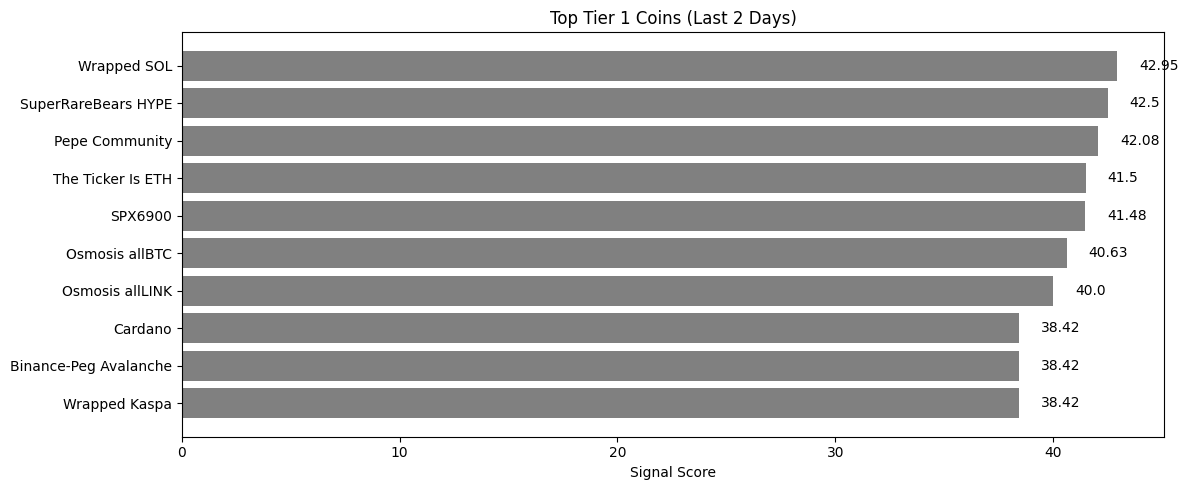

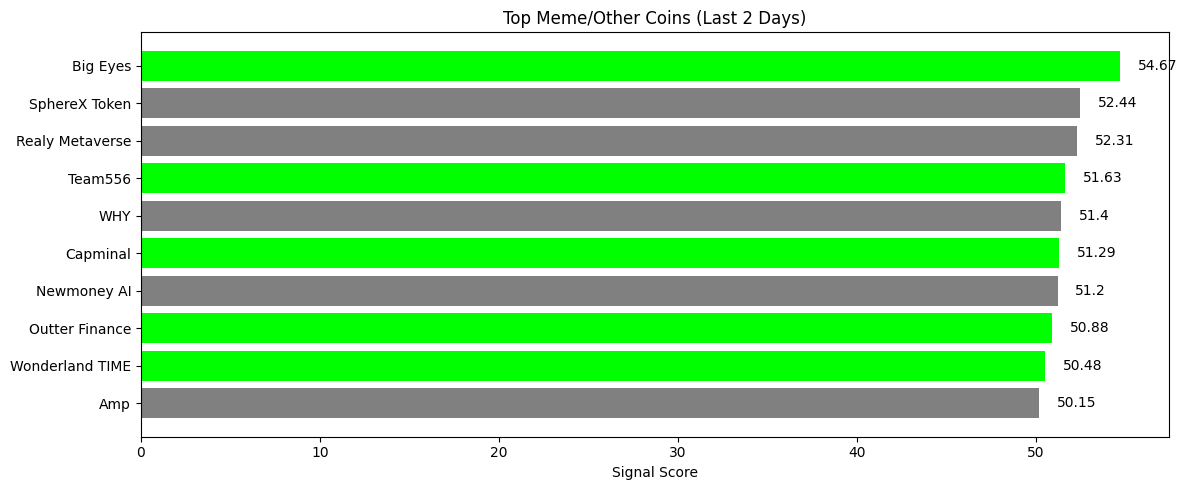

In [15]:
# Revised analysis for updated sentiment oracle output
import pandas as pd
import matplotlib.pyplot as plt

# Load the new overall sentiment CSV
import requests
file_path = "E:/sentiment-oracle/data/overall_coin_sentiment.csv"
df = pd.read_csv(file_path)


# Inspect signal distribution
signal_counts = df["signal"].value_counts()
print("Signal distribution:\n", signal_counts)

# Load top 500 coins from CoinGecko
cg_url = "https://api.coingecko.com/api/v3/coins/markets"
cg_params = {"vs_currency": "usd", "order": "market_cap_desc", "per_page": 500, "page": 1}
cg_response = requests.get(cg_url, params=cg_params)
top_coins = pd.DataFrame(cg_response.json())
top_symbols = set(top_coins["symbol"].str.upper())

# Assign coin tiers
df["coin_tier"] = df["coin"].apply(lambda x: "Tier 1" if x in top_symbols else "Meme/Other")

# Aggregate basic metrics per coin
agg = df.groupby(["coin", "coin_name"]).agg({
    "mention_count": "sum",
    "buy_count": "sum",
    "sell_count": "sum",
    "weighted_sentiment": "mean",
    "pct_buy_calls": "mean"
}).reset_index()

# Add final score (0–100 scale)
agg["signal_score"] = (
    agg["weighted_sentiment"].clip(0, 1) * 50 +
    agg["pct_buy_calls"].clip(0, 1) * 30 +
    (agg["mention_count"].clip(0, 10) / 10) * 20
).round(2)

# Merge with latest signal labels from source
latest_signals = df.sort_values("date").drop_duplicates("coin", keep="last")[["coin", "signal", "coin_tier"]]
latest_signals = df.sort_values("date").drop_duplicates("coin", keep="last")[["coin", "signal", "coin_tier"]]
agg = agg.merge(latest_signals, on="coin", how="left")

# Fill missing coin_tier from merge
agg["coin_tier"] = agg["coin_tier"].fillna("Unknown")

# Sort by score

# Separate Tier 1 and Meme coins
tier1_all = agg[agg["coin_tier"] == "Tier 1"].sort_values("signal_score", ascending=False)
top_buys = tier1_all[tier1_all["signal"] == "BUY"].head(3)
remaining_needed = max(0, 10 - len(top_buys))
top_rest = tier1_all[~tier1_all.index.isin(top_buys.index)].head(remaining_needed)
tier1 = pd.concat([top_buys, top_rest]).sort_values("signal_score", ascending=False)
tierM = agg[agg["coin_tier"] != "Tier 1"].sort_values("signal_score", ascending=False).head(10)
top = agg.sort_values("signal_score", ascending=False).head(20)
print("Top signals:")
print(top[["coin", "coin_name", "signal", "signal_score"]])

# Bar plot of top Tier 1
plt.figure(figsize=(12, 5))
colors1 = tier1["signal"].map({"STRONG BUY": "green", "BUY": "lime", "NEUTRAL": "gray", "SELL": "red", "STRONG SELL": "darkred"})
plt.barh(tier1["coin_name"], tier1["signal_score"], color=colors1)
for i, v in enumerate(tier1["signal_score"]):
    plt.text(v + 1, i, str(v), va='center')
plt.xlabel("Signal Score")
plt.title("Top Tier 1 Coins (Last 2 Days)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Bar plot of top Meme/Other
plt.figure(figsize=(12, 5))
colorsM = tierM["signal"].map({"STRONG BUY": "green", "BUY": "lime", "NEUTRAL": "gray", "SELL": "red", "STRONG SELL": "darkred"})
plt.barh(tierM["coin_name"], tierM["signal_score"], color=colorsM)
for i, v in enumerate(tierM["signal_score"]):
    plt.text(v + 1, i, str(v), va='center')
plt.xlabel("Signal Score")
plt.title("Top Meme/Other Coins (Last 2 Days)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
